In [1]:
import dask.array as da
import warnings

import dask.array as da
from sklearn.pipeline import Pipeline
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from dask_ml.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas
from toolz.curried import groupby, valmap, pipe, pluck, merge_with, merge
from toolz.curried import map as fmap

from pymks.fmks.data.elastic_fe import solve
from pymks.fmks.data.multiphase import generate

from pymks.fmks.plot import plot_microstructures
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation, FlattenTransformer
from dask.distributed import Client, progress
import time
from mpl_toolkits import mplot3d
%matplotlib notebook
%load_ext memory_profiler

In [2]:
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
da.random.seed(10)
np.random.seed(10)

tmp = [
    generate(shape=(100, 101, 101,101), grain_size=x, volume_fraction=(0.5, 0.2,0.3), chunks=25, percent_variance=0.15)
    for x in [(15, 2,2), (2,2, 15), (7,7, 7), (9, 9,3), (9,9, 9), (2, 2,2)]
]
x_data_gen = da.concatenate(tmp)

In [4]:
x_data_gen

dask.array<concatenate, shape=(600, 101, 101, 101), dtype=int64, chunksize=(25, 101, 101, 101), chunktype=numpy.ndarray>

In [5]:
print(x_data_gen.shape)
print(x_data_gen.chunks)


(600, 101, 101, 101)
((25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25), (101,), (101,), (101,))


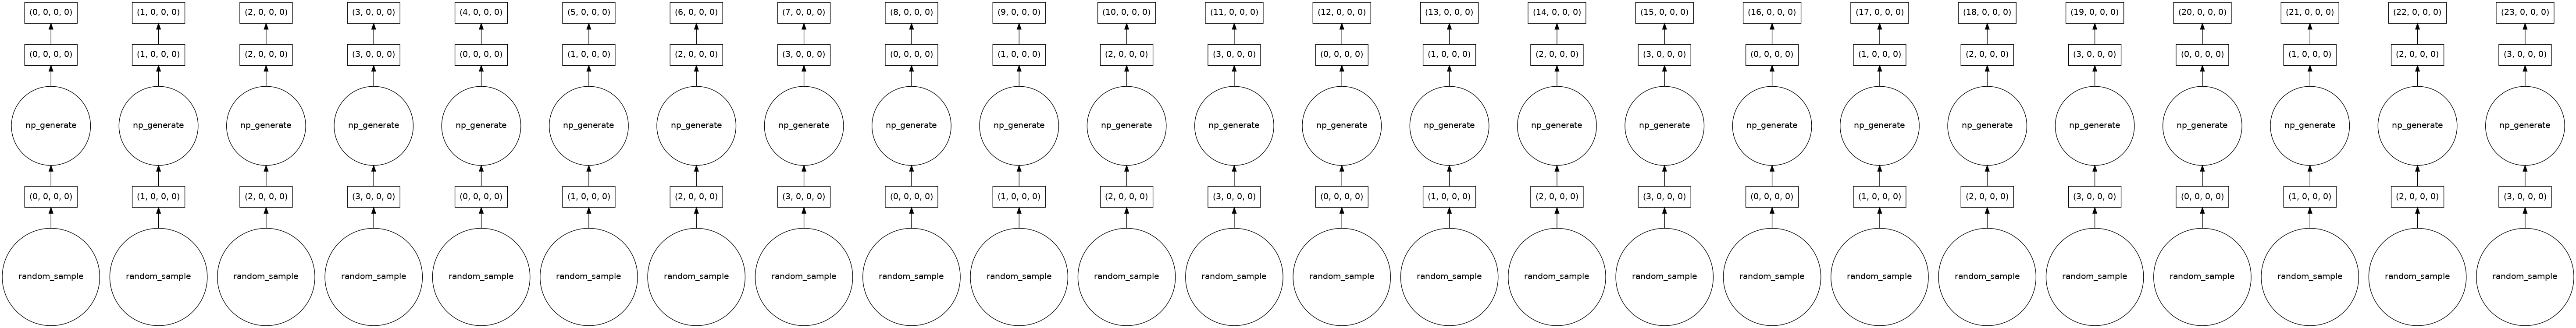

In [6]:
x_data_gen.visualize()

In [7]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43171 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.59 GB


In [8]:
# client = Client( threads_per_worker=2,
#                 n_workers=2, memory_limit='8GB')
# client

In [9]:
bl1 = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])

In [10]:
tic = time.time()
%memit a=bl1.fit(x_data_gen)
toc = time.time()
print(tic-toc)

peak memory: 219.80 MiB, increment: 14.20 MiB
-59.437315940856934


In [11]:
tic = time.time()
%memit b=bl1.transform(x_data_gen).compute()
toc = time.time()
print(tic-toc)
print(b)

peak memory: 224.40 MiB, increment: 4.60 MiB
-60.120423555374146
[[  6.63186425  -0.33345751   0.20069647]
 [ 10.09653753  -0.33510672   0.2022799 ]
 [-12.90878497  -0.32687167   0.18034575]
 ...
 [ 11.11305912  -0.3928645   -0.02988136]
 [ 19.97482236  -0.3965433   -0.02194133]
 [ -7.00099671  -0.38569732  -0.04620993]]


In [12]:
da.random.seed(10)
np.random.seed(10)
tmp2 = [
    generate(shape=(100, 101, 101,101), grain_size=x, volume_fraction=(0.5, 0.2,0.3), chunks=20, percent_variance=0.15)
    for x in [(15, 2,2), (2,2, 15), (7,7, 7), (9, 9,3), (9,9, 9), (2, 2,2)]
]
x_data_gen2 = da.concatenate(tmp2)

In [13]:
tic = time.time()
%memit a2=bl1.fit(x_data_gen2)
toc = time.time()
print(tic-toc)

peak memory: 233.24 MiB, increment: 8.72 MiB
-57.32075381278992


In [14]:
tic = time.time()
%memit b2=bl1.transform(x_data_gen2).compute()
toc = time.time()
print(tic-toc)
print(b2)

peak memory: 237.11 MiB, increment: 3.87 MiB
-55.54633283615112
[[ 16.85441973   0.33408693  -0.19618105]
 [ 25.67381245   0.33917288  -0.18851464]
 [-20.06429403   0.32959643  -0.17627906]
 ...
 [ 18.33761214   0.39153544   0.03187277]
 [ 18.76685197   0.39120024   0.03178419]
 [-22.6513789    0.38215066   0.04763132]]


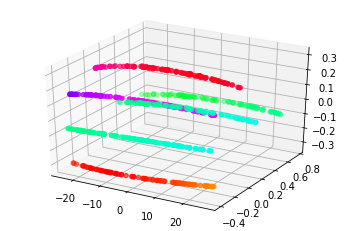

In [15]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# z_line = np.linspace(0, 15, 1000)
# x_line = np.cos(z_line)
# y_line = np.sin(z_line)
# ax.plot3D(x_line, y_line, z_line, 'gray')

z_points = b[:,2]
x_points = b[:,0]
y_points = b[:,1]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()

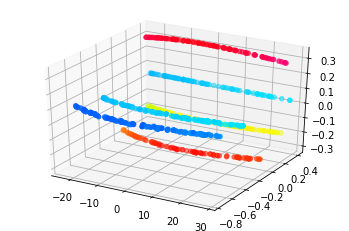

In [16]:

fig = plt.figure()
ax = plt.axes(projection="3d")

# z_line = np.linspace(0, 15, 1000)
# x_line = np.cos(z_line)
# y_line = np.sin(z_line)
# ax.plot3D(x_line, y_line, z_line, 'gray')

z_points = b2[:,2]
x_points = b2[:,0]
y_points = b2[:,1]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()
